<a href="https://colab.research.google.com/github/AmitCosmo/hubble-data/blob/main/H%3Dl_t_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
from lmfit import Model
import matplotlib.pyplot as plt

# Load the Hubble dataset with errors (z: redshift, H: Hubble parameter, err: error)
data = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt', unpack=True)

z = data[0]
H = data[1]
err = data[2]

# Define the function to be fitted
def hubble_func(z, h0, l):
    return h0 * (1 + z) ** (1/l)

# Create an lmfit Model object
model = Model(hubble_func)

# Set initial parameter values
params = model.make_params(h0=70, l=0.1)

# Perform the fit
result = model.fit(H, params, z=z, weights=1/err)

# Get the best-fit parameters
best_fit_parameters = result.params

# Print the best-fit parameters
print("Best-fit Parameters:")
print("h0 =", best_fit_parameters['h0'].value)
print("l =", best_fit_parameters['l'].value)



Best-fit Parameters:
h0 = 62.171401349643084
l = 0.973233807251953


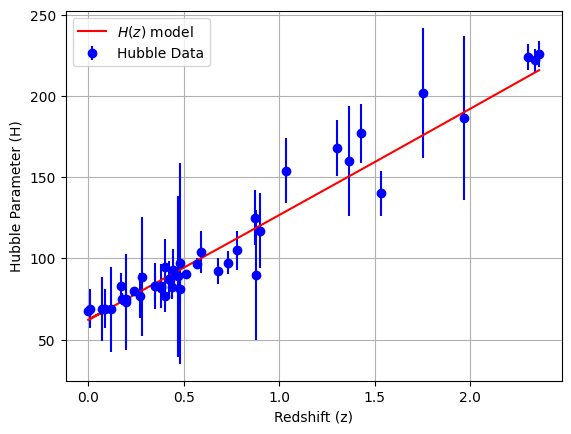

In [ ]:
# Plot the data with error bars
plt.errorbar(z, H, yerr=err, fmt='bo', label='Hubble Data')

# Generate the predicted values from the best-fit parameters
predicted_H = model.eval(best_fit_parameters, z=z)

# Plot the best-fit line
plt.plot(z, predicted_H, 'r-', label='$H(z)$ model')

# Add labels and legend
plt.xlabel('Redshift (z)')
plt.ylabel('Hubble Parameter (H)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [43]:
!pip install corner

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform
import time
import corner
import math
import scipy.optimize as op
# from numpy import *

In [45]:
x,y,yerr = np.loadtxt('https://raw.githubusercontent.com/AmitCosmo/hubble-data/main/H_46%20%20data%20set.txt', unpack=True)

In [47]:
#Initial seeds
h0_ini,l_ini=70,0.1

#Define log-Likelihood Function

def likelihood(theta, x, y, yerr):
    h0, l = theta
    model = h0 * (1 + x) ** (1/l)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(6.28*inv_sigma2)))

In [48]:
#Define Prior Function
def prior(theta):
    try:
        h0, l = theta
        if 0 < h0 < 100.0 and 0.1 < l < 2.0:
            return 0.0
    except ValueError:
        pass
    return -np.inf


#Degine Posterior Function
def posterior(theta, x, y, yerr):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + likelihood(theta, x, y, yerr))

In [49]:
#Define number of parameter, steps, burn-in phase
ndim=2
nsteps=200000
nburn_in=1000

initials=h0_ini,l_ini

In [50]:
start_time = time.time()


#Define Metropolis-Hastings Function
def Metropolis_Hastings(parameter_init, iteration_time):
    result = []
    result.append(parameter_init)
    for t in range(iteration_time):
        step_var = [1, 0.01]
        proposal = np.zeros(2)
        for i in range(2):
            proposal[i] = norm.rvs(loc=result[-1][i], scale=step_var[i])
            probability = np.exp(posterior(proposal,x,y,yerr) - posterior(result[-1],x,y,yerr))
            if (uniform.rvs() < probability):
                result.append(proposal)
            else:
                result.append(result[-1])
    return (result)

result = Metropolis_Hastings(initials, nsteps)

result = result[nburn_in:]
a_result = np.zeros(nburn_in)
b_result = np.zeros(nburn_in)
samples_MH=np.array(result)
h0_mcmc, l_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples_MH,
                       [16, 50, 84],axis=0)))

print("----------------------------------------------------------------------\n")
print("Execution time with steps=%s------> %6.3f seconds" %
      (nsteps,(time.time() - start_time)))
print("----------------------------------------------------------------------\n")

<ipython-input-50-d5b595428c90>:13: RuntimeWarning: overflow encountered in exp
  probability = np.exp(posterior(proposal,x,y,yerr) - posterior(result[-1],x,y,yerr))


----------------------------------------------------------------------

Execution time with steps=200000------> 75.002 seconds
----------------------------------------------------------------------



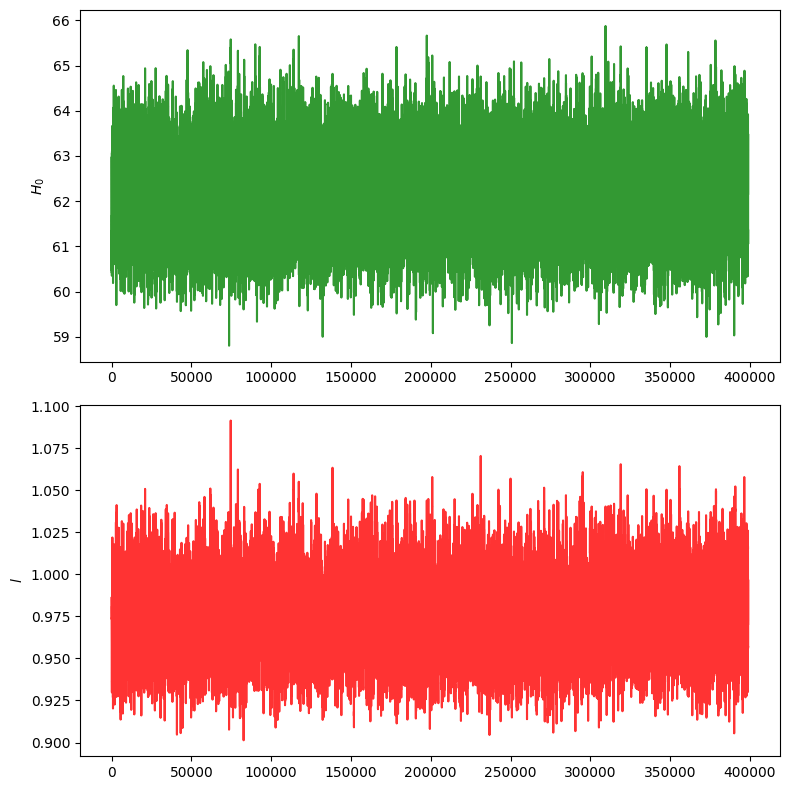

In [52]:
# Plot the traceplots of the MCMC chains
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
samples = samples_MH.T

# Plot the traceplot of H0
axes[0].plot(samples[0], "g", alpha=0.8)
axes[0].set_ylabel("$H_0$")

# Plot the traceplot of m
axes[1].plot(samples[1], "r", alpha=0.8)
axes[1].set_ylabel("$l$")

plt.tight_layout()
# plt.savefig("FLCDM_H_31_MH_traces.png")
plt.show()

In [53]:
print("""MCMC result:
    H0 = {0[0]} +{0[1]} -{0[2]}
    l = {2[0]} +{2[1]} -{2[2]}
""".format(h0_mcmc, h0_ini, l_mcmc, l_ini))

MCMC result:
    H0 = 62.19406192573431 +0.8463536599129213 -0.8213287998725036
    l = 0.9742967175068862 +0.022310501582604836 -0.020753091182741712



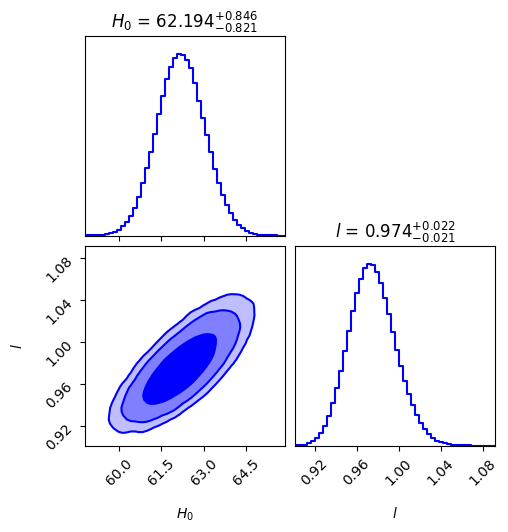

In [56]:
fig = corner.corner(samples_MH,bins=50,color="b",labels=["$H_0$","$l$"],
                    fill_contours=True,
                    levels=(0.68,0.95,0.99,),
                    title_fmt='.3f',plot_datapoints=False,smooth=True, smooth1d=True, smooth3d=True, show_titles=True, plot_contours=True)
#fig.savefig("FLCDM_H_46_MH.png")